In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

2025-10-03 13:33:32.663406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759498412.839410      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759498412.894254      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path='/kaggle/input/brain-tumor-classification-mri'
train_path='/kaggle/input/brain-tumor-classification-mri/Training'
test_path='/kaggle/input/brain-tumor-classification-mri/Testing'

In [3]:
from PIL import Image

img1 = Image.open("/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg")
img2 = Image.open("/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(10).jpg")

print("Size:", img1.size)   
print("Size:", img2.size)   

Size: (495, 619)
Size: (386, 406)


In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=64
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2870 files belonging to 4 classes.


I0000 00:00:1759498426.261086      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759498426.261805      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
IMG_SIZE=(224,224)
BATCH_SIZE=64
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 394 files belonging to 4 classes.


In [6]:
X=[]
y=[]

for images, labels in train_ds:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape, y.shape)

(2870, 224, 224, 3) (2870,)


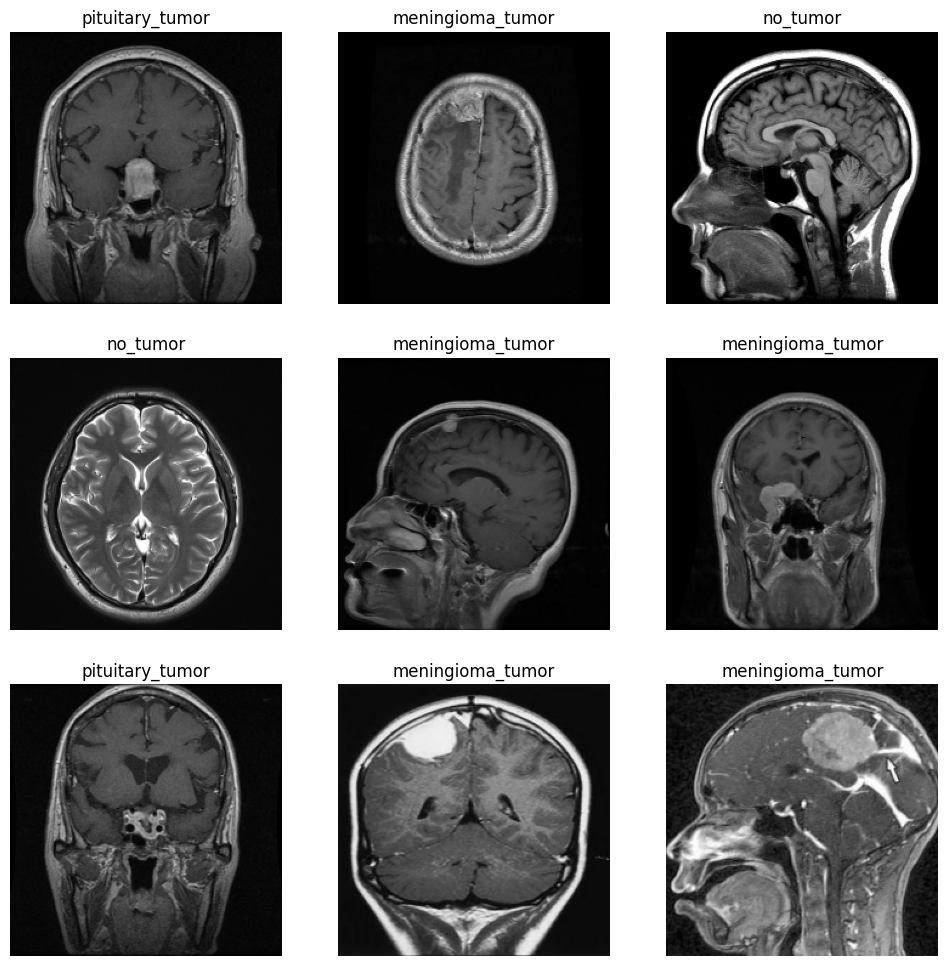

In [7]:
class_names = train_ds.class_names  
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):  
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

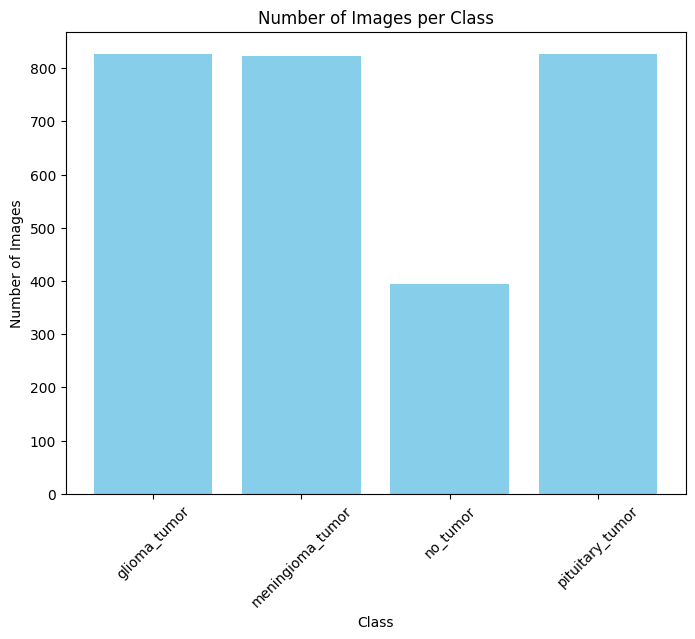

In [8]:
counts= {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in class_names}
plt.figure(figsize=(8,6))
plt.bar(counts.keys(), counts.values(), color="skyblue")
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [9]:
X=X/255.0
le=LabelEncoder()
y=le.fit_transform(y)
y_cate=to_categorical(y)

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y_cate,test_size=0.2 , random_state=42, stratify=y) # keep the same class distribution in train and test sets

In [11]:
data_gen= ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.02,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False
)
data_gen.fit(X_train)

In [12]:
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(1024,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_cate.shape[1], activation='softmax')) 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.build(input_shape=(None, 224, 224, 3)) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 1024)   │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,026,692 (22.99 MB)

 Trainable params: 6,026,436 (22.99 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [16]:
train_generator = data_gen.flow(
    X_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

In [17]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1759498441.551025      69 service.cc:148] XLA service 0x7b023c4090d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759498441.552452      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759498441.552474      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759498441.972386      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4062 - loss: 1.4223  

I0000 00:00:1759498449.014890      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.5297 - loss: 1.1910 - val_accuracy: 0.3101 - val_loss: 4.5255 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.6295 - loss: 0.9505 - val_accuracy: 0.2875 - val_loss: 4.7965 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.6292 - loss: 0.9296 - val_accuracy: 0.5958 - val_loss: 0.9325 - learning_rate: 0.0010
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.6939 - loss: 0.8090 - val_accuracy: 0.6742 - val_loss: 0.8861 - learning_rate: 0.0010
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.7181 - loss: 0.7361 - val_accuracy: 0.7962 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.7480 - loss: 0.6714 - val_accuracy: 0.6777 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.7642 - loss: 0.6367 - val_

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8011 - loss: 0.5620
Test Loss: 0.5488
Test Accuracy: 0.7962


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Test Accuracy: 0.7962

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       165
           1       0.67      0.78      0.72       165
           2       0.75      0.75      0.75        79
           3       0.87      0.94      0.90       165

    accuracy                           0.80       574
   macro avg       0.80      0.79      0.79       574
weighted avg       0.81      0.80      0.80       574



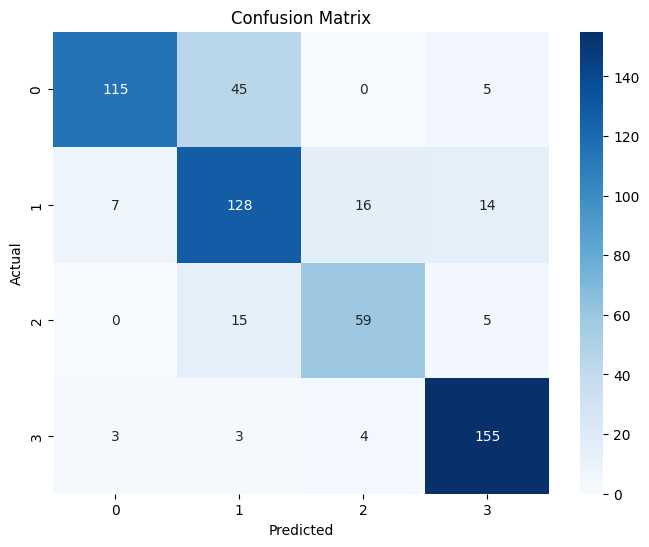

In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  

acc = accuracy_score(y_true, y_pred_classes)
print(f"\033[1mTest Accuracy: {acc:.4f}\033[0m\n")  

target_names = [str(c) for c in le.classes_] 
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("\033[1mClassification Report:\033[0m")  
print(report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


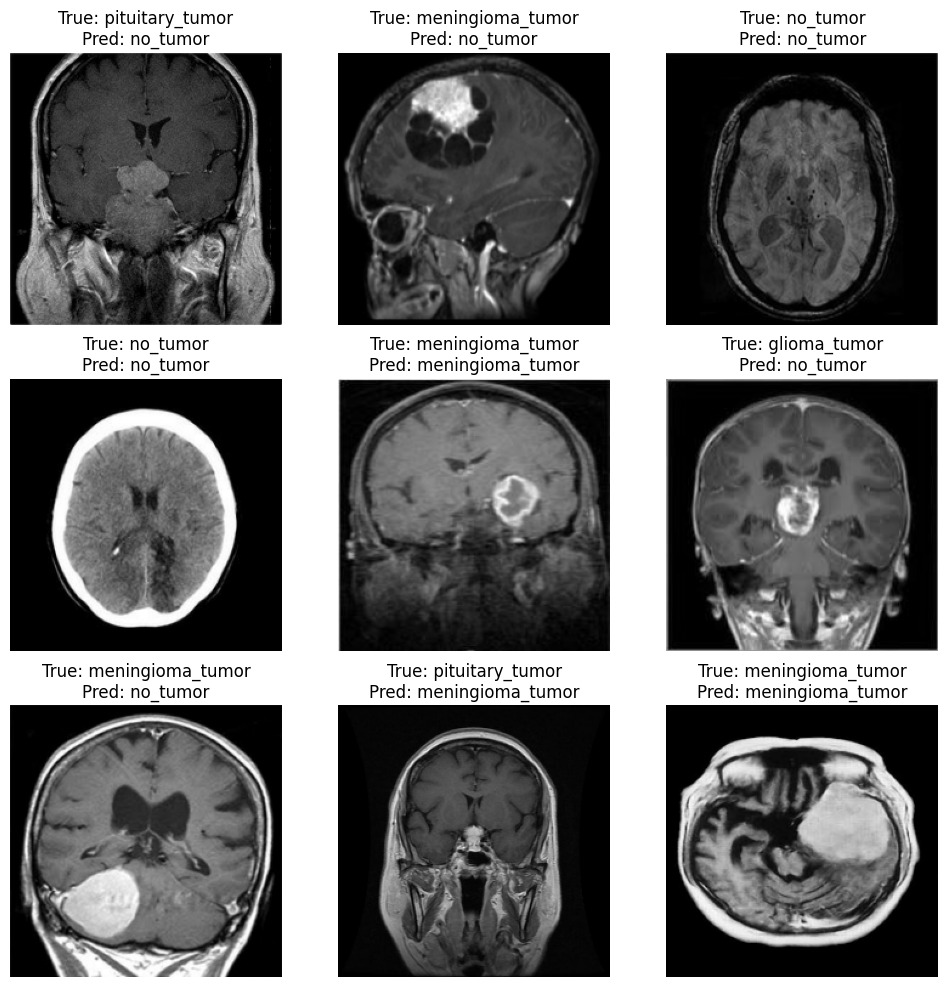

In [20]:
class_names = train_ds.class_names  

plt.figure(figsize=(12, 12))

for images, labels in test_ds.take(1):  
    preds = model.predict(images)  
    pred_classes = np.argmax(preds, axis=1)

    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = class_names[labels[i]]
        pred_label = class_names[pred_classes[i]]

        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

plt.show()


In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),  
    y=y
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.8686440677966102, 1: 0.8728710462287105, 2: 1.8164556962025316, 3: 0.8675937122128174}


In [22]:
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    epochs=30,
    class_weight=class_weights   
)


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.7701 - loss: 0.6223 - val_accuracy: 0.6551 - val_loss: 0.8510 - learning_rate: 2.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.7708 - loss: 0.5916 - val_accuracy: 0.6934 - val_loss: 0.7130 - learning_rate: 2.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.8159 - loss: 0.5555 - val_accuracy: 0.7474 - val_loss: 0.6356 - learning_rate: 2.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.8189 - loss: 0.4851 - val_accuracy: 0.7578 - val_loss: 0.5652 - learning_rate: 2.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.8332 - loss: 0.4930 - val_accuracy: 0.8031 - val_loss: 0.5576 - learning_rate: 2.0000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.8442 - loss: 0.4439 - val_accuracy: 0.6951 - val_loss: 0.7993 - learning_rate: 2.0000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - acc